In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import random
import pandas as pd
import numpy as np
import cv2

from keras import utils
from keras.preprocessing.image import load_img

In [3]:
binary = np.load('gdrive/MyDrive/train_data/binary.npz')
keys = binary.files
element = binary[keys[0]].astype('int')
element

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
train_keys = []
val_keys = []

for i in range(len(keys)):
    if i % 11 == 0:
      val_keys.append(keys[i])
    else:
      train_keys.append(keys[i])

In [5]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)
def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=5, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        #RandomCrop(256, 256),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #Resize(64, 64),
        RandomRotate90(p=0.2),
        ElasticTransform(1.), 
        HorizontalFlip(p=0.3),
        Cutout(p=1.),
        #Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.4),
        ], p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.4),
            IAAPiecewiseAffine(p=0.4),
        ], p=0.5),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.4),
        HueSaturationValue(p=0.5),
         
        
        
    ],
        p=p)

In [6]:
def keras_generator(gen_keys, batch_size=1, image_size=(1024,1024)):
    augmentation = strong_aug(p=1.0)
    while True:
        x_batch = []
        y_batch = []
        for i in range(batch_size):
            #TODO аугментация https://www.youtube.com/watch?v=OWK8VlgJM4I 1:58:05
            img_name = random.choice(gen_keys)
            img = load_img('gdrive/MyDrive/train_data/images/{}'.format(img_name), target_size=image_size)
            img = np.asarray(img, dtype='uint8')
            

            mask = binary[img_name].astype('int')
            img_mask = Image.fromarray((mask * 255).astype(np.uint8))
            img_mask = img_mask.resize(image_size, resample=Image.BILINEAR)
            mask = np.asarray(img_mask, dtype=int)
            mask = mask // 255
            
            data={'image' : img,'mask' : mask.astype('uint8')}
            augmented = augmentation(**data)

            crop_img, crop_mask = augmented["image"], augmented["mask"]

            x_batch += [crop_img/255]
            y_batch += [crop_mask]


        yield np.asarray(x_batch), np.expand_dims(y_batch, -1)

In [ ]:
for x,y in keras_generator(val_keys,1):
  break

In [ ]:
print(x)

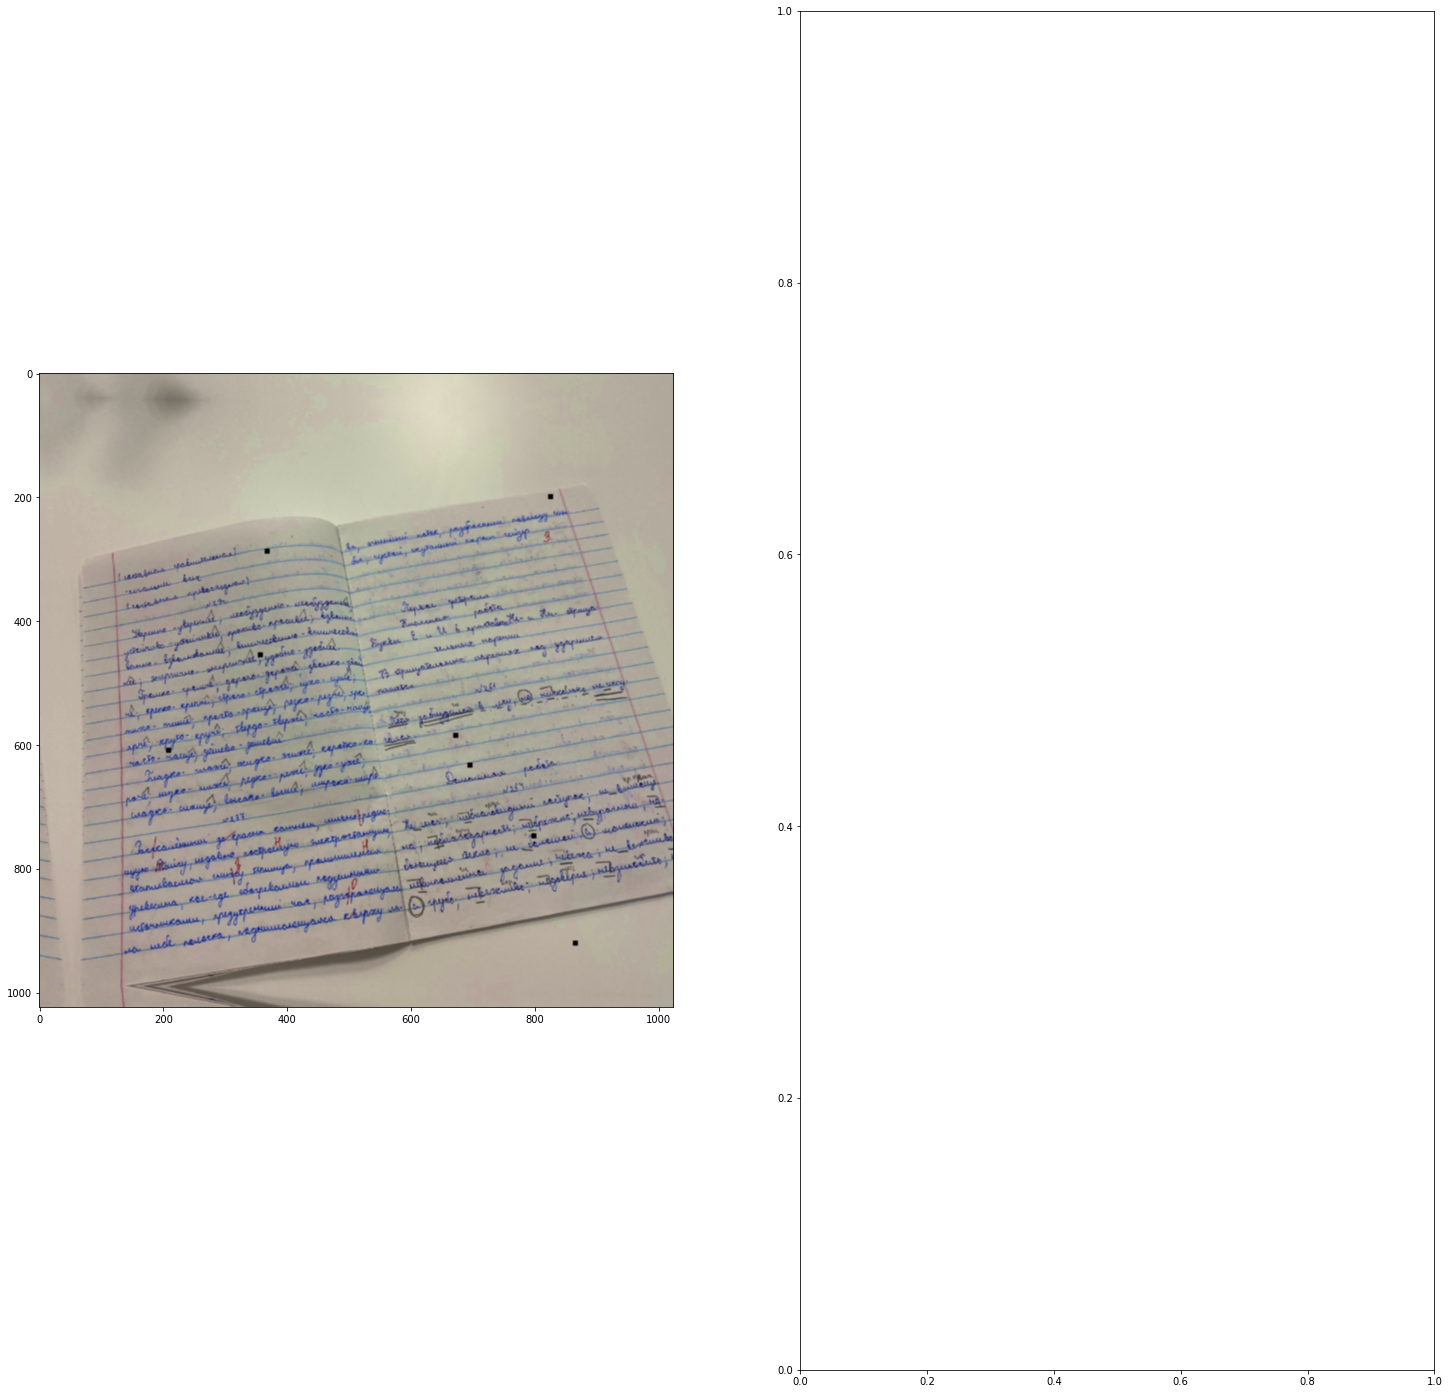

In [ ]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])


In [7]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation, Concatenate

#512 1024 2048
inp = Input(shape=(1024, 1024, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(512, (3, 3), padding='same')(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)

conv_5_2 = Conv2D(512, (3, 3), padding='same')(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)

pool_5 = MaxPooling2D(2)(conv_5_2)

conv_6_1 = Conv2D(1024, (3, 3), padding='same')(pool_5)
conv_6_1 = Activation('relu')(conv_6_1)

conv_6_2 = Conv2D(1024, (3, 3), padding='same')(conv_6_1)
conv_6_2 = Activation('relu')(conv_6_2)

pool_6 = MaxPooling2D(2)(conv_6_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_6)
conc_1 = Concatenate()([up_1, conv_6_2])
conv_up_1_1 = Conv2D(1024, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(1024, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([up_2, conv_5_2])
conv_up_2_1 = Conv2D(512, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(512, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([up_3, conv_4_2])
conv_up_3_1 = Conv2D(256, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(256, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([up_4, conv_3_2])
conv_up_4_1 = Conv2D(128, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(128, (3, 3), padding='same')(conv_up_4_1)
conv_up_4_2 = Activation('relu')(conv_up_4_2)

up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_5 = Concatenate()([up_5, conv_2_2])
conv_up_5_1 = Conv2D(64, (3, 3), padding='same')(conc_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)

conv_up_5_2 = Conv2D(64, (3, 3), padding='same')(conv_up_5_1)
conv_up_5_2 = Activation('relu')(conv_up_5_2)

up_6 = UpSampling2D(2, interpolation='bilinear')(conv_up_5_2)
conc_6 = Concatenate()([up_6, conv_1_2])
conv_up_6_1 = Conv2D(32, (3, 3), padding='same')(conc_6)
conv_up_6_1 = Activation('relu')(conv_up_6_1)

conv_up_6_2 = Conv2D(32, (3, 3), padding='same')(conv_up_6_1)
result = Activation('sigmoid')(conv_up_6_2)

model = Model(inputs=inp, outputs=result)

In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

In [ ]:
from classification_models.keras import Classifiers

ResNet34, preprocess_input = Classifiers.get('resnet34')

In [ ]:
model=ResNet34(input_shape=(1024,1024,3))

In [ ]:
model.summary()

In [ ]:
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = ResNet34(weights='imagenet', input_shape=(1024,1024,3), include_top=False)
 
base_out = base_model.output

# up = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(base_out)
# up = Conv2D(1, (1,1), strides=(1, 1))(up)


# model = Model(input=base_model.input, output=up)

In [ ]:
base_out

In [ ]:
base_model.summary()

In [ ]:
conv1 = base_model.get_layer('conv1_relu').output
conv2 = base_model.get_layer('conv2_block1_out').output
conv3 = base_model.get_layer('conv3_block2_out').output
conv4 = base_model.get_layer('conv4_block6_out').output
conv5 = base_model.get_layer('conv5_block3_out').output


## CODE

inp = base_model.get_layer('input_2').output

In [ ]:
conv5

<KerasTensor: shape=(None, 32, 32, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(1024, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(256, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(128, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(64, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(32, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('softmax')(conv_conc_5)


In [ ]:
model = Model(inputs=base_model.input, outputs=conv_conc_5)

In [8]:
from keras.callbacks import ModelCheckpoint
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
best_w = ModelCheckpoint('gdrive/MyDrive/train_data/selfmade_unet_best.h5',
                          monitor='val_loss',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=True,
                          mode='auto',
                          period=1)

last_w = ModelCheckpoint('gdrive/MyDrive/train_data/selfmade_unet_last.h5',
                          monitor='val_loss',
                          verbose=0,
                          save_best_only=False,
                          save_weights_only=True,
                          mode='auto',
                          period=1)


callbacks = [best_w, last_w]


from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.0003)


model.compile(adam, 'binary_crossentropy',metrics=['acc',f1_m,precision_m, recall_m])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 2
model.fit_generator(keras_generator(train_keys, batch_size),
                    steps_per_epoch=150,
                    epochs=25,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=keras_generator(val_keys, batch_size),
                    validation_steps=50,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
150/150 [==============================] - 1102s 7s/step - loss: 0.4384 - acc: 0.0450 - f1_m: 0.4537 - precision_m: 0.3335 - recall_m: 3.5790 - val_loss: 0.3818 - val_acc: 0.0000e+00 - val_f1_m: 1.4294 - val_precision_m: 0.7444 - val_recall_m: 21.2287
Epoch 2/25
 65/150 [============>.................] - ETA: 7:10 - loss: 0.3554 - acc: 9.9220e-04 - f1_m: 1.5026 - precision_m: 0.8259 - recall_m: 15.9296

In [ ]:
def keras_generator1(gen_keys, batch_size=1, image_size=(1024,1024)):
    while True:
        x_batch = []
        y_batch = []
        for i in range(batch_size):
            #TODO аугментация https://www.youtube.com/watch?v=OWK8VlgJM4I 1:58:05
            img_name = random.choice(gen_keys)
            img = load_img('gdrive/MyDrive/train_data/images/{}'.format(img_name), target_size=image_size)
            img = np.asarray(img, dtype=int)
            img = img / 255

            mask = binary[img_name].astype('int')
            img_mask = Image.fromarray((mask * 255).astype(np.uint8))
            img_mask = img_mask.resize(image_size, resample=Image.BILINEAR)
            mask = np.asarray(img_mask, dtype=int)
            mask = mask // 255
            
            x_batch += [img]
            y_batch += [mask]


        yield np.asarray(x_batch), np.asarray(y_batch)

In [ ]:
for x,y in keras_generator1(val_keys,1):
  break

In [ ]:
x=load_img('gdrive/MyDrive/train_data/images/99_2.JPG', target_size=(1024,1024))

In [ ]:
q=[]

x=np.asarray(x)
q+=[x]
q=np.asarray(q)
q.shape

(1, 1024, 1024, 3)

In [ ]:
pred = model.predict(q)

In [ ]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))

axes[0].imshow(pred[im_id, ..., 0]>0.5 )

plt.show()

In [ ]:
print(pred)

In [ ]:
from keras.models import load_model
model.load_weights('gdrive/MyDrive/train_data/selfmade_unet_best.h5')

In [ ]:
pred = model.predict(x)

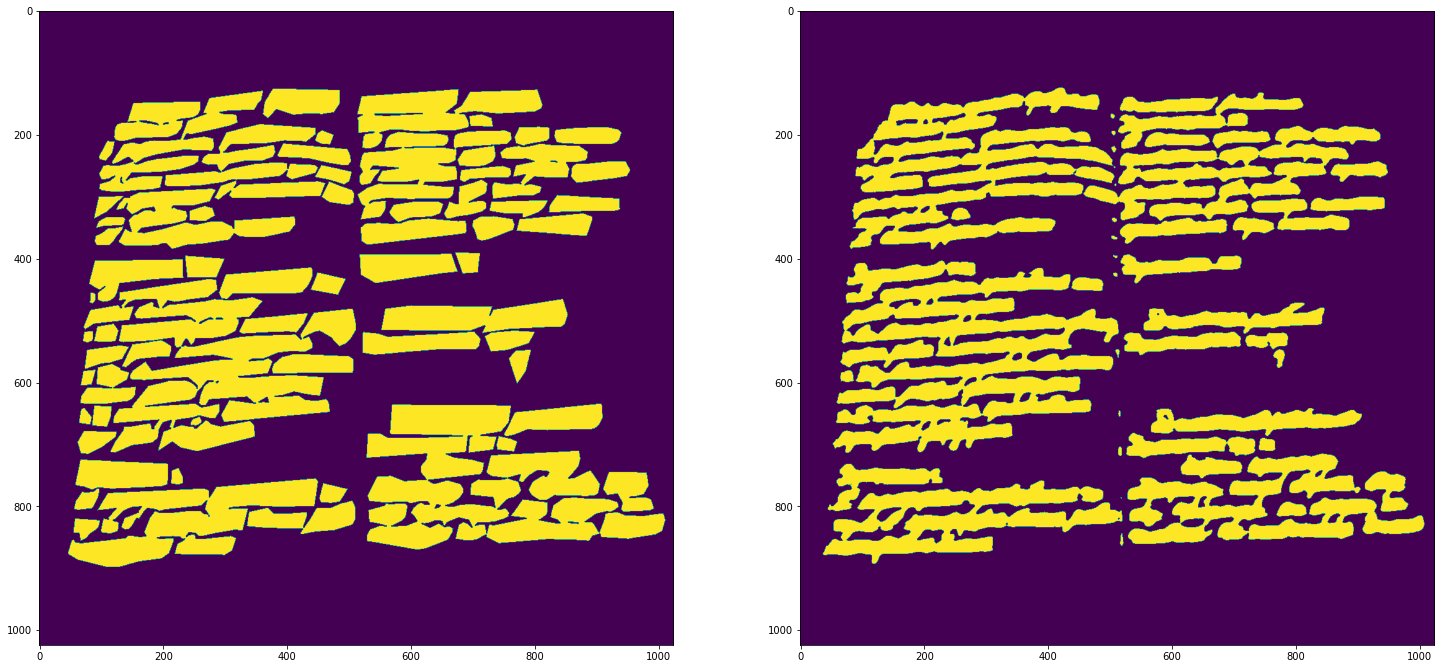

In [ ]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(y[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5 )

plt.show()

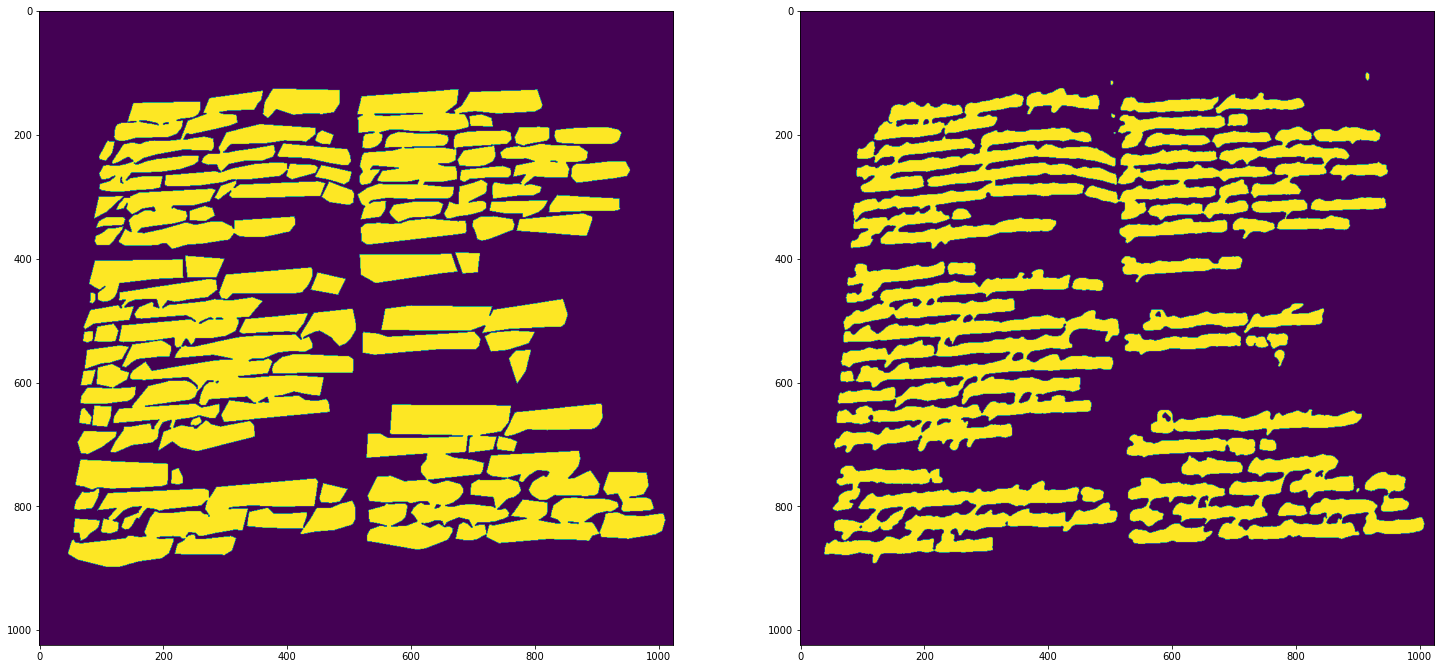

In [ ]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(y[im_id])
axes[1].imshow(pred[im_id, ..., 0]>0.5 )

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(y[im_id])